<a href="https://colab.research.google.com/github/choki0715/lecture/blob/master/AR_ARMA_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd 
import numpy as np 
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
#from pandas.tools.plotting import autocorrelation_plot

import statsmodels
print(statsmodels.__version__)

0.10.2


In [50]:

from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt
#from pandas.tools.plotting import lag_plot
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
import seaborn as sns
from statsmodels.tsa.ar_model import AR ## old version AR 
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [51]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv

--2022-05-14 03:55:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1596 (1.6K) [text/plain]
Saving to: ‘monthly_champagne_sales.csv.1’

monthly_champagne_s 100%[===================>]   1.56K  --.-KB/s    in 0s      

2022-05-14 03:55:56 (26.2 MB/s) - ‘monthly_champagne_sales.csv.1’ saved [1596/1596]



In [52]:
data = pd.read_csv('monthly_champagne_sales.csv')
data.head()
data

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
...,...,...
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413


In [53]:
dates = pd.date_range(start='1964-01-01', freq='MS', periods=len(data))
dates

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', length=105, freq='MS')

In [54]:
data.set_index(dates,inplace=True)
print(data)

data.drop('Month',axis=1,inplace=True)
print(data)

              Month  Sales
1964-01-01  1964-01   2815
1964-02-01  1964-02   2672
1964-03-01  1964-03   2755
1964-04-01  1964-04   2721
1964-05-01  1964-05   2946
...             ...    ...
1972-05-01  1972-05   4618
1972-06-01  1972-06   5312
1972-07-01  1972-07   4298
1972-08-01  1972-08   1413
1972-09-01  1972-09   5877

[105 rows x 2 columns]
            Sales
1964-01-01   2815
1964-02-01   2672
1964-03-01   2755
1964-04-01   2721
1964-05-01   2946
...           ...
1972-05-01   4618
1972-06-01   5312
1972-07-01   4298
1972-08-01   1413
1972-09-01   5877

[105 rows x 1 columns]


In [57]:
train = (data[data.index < '1969-10-01'])
test = (data[data.index >= '1969-10-01'])
#print(train, test)

# AR 모델

In [65]:
model = AR(train)
model_fit = model.fit()
#model_fit.summary()

In [66]:
#How many lags considered statistically, what are their beta values
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 11
Coefficients: const        1697.722489
L1.Sales        0.633575
L2.Sales       -0.451075
L3.Sales        0.465719
L4.Sales       -0.643086
L5.Sales        0.492391
L6.Sales       -0.434121
L7.Sales        0.521092
L8.Sales       -0.660454
L9.Sales        0.472919
L10.Sales      -0.481942
L11.Sales       0.760421
dtype: float64


In [67]:
# Predicting the test values
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [68]:
print('The first test value in Sales :',test.values[1],'and its Predicted value : ',predictions.values[1])

The first test value in Sales : [10803] and its Predicted value :  10357.72533179987


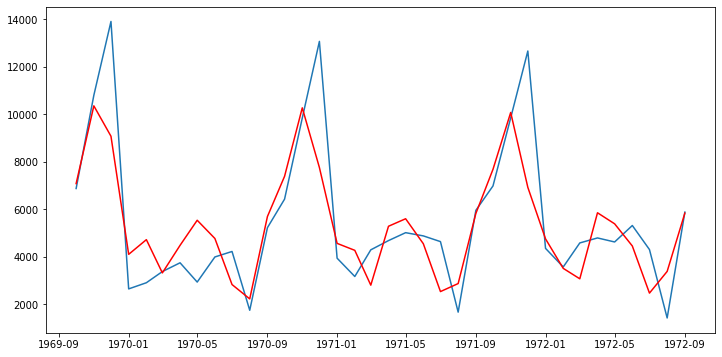

In [13]:
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [14]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], predictions))
rmse = round(rmse, 3)

In [15]:
# Mean Absolute Percentage Error
abs_error = np.abs(test['Sales']-predictions)
actual = test['Sales']
mape = np.round(np.mean(abs_error/actual),3)
resultsDf = pd.DataFrame({'Method':['Auto Regressive'], 'RMSE': [rmse]})
resultsDf
mape

0.277

In [16]:
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,1864.15,0.277


# ARMA모델
## The model involves specifying the order for the AR(p) and MA(q) model

In [17]:
# Define the p and q parameters to take any value between 0 and 2
p = range(0, 7)
q = range(0,1)

In [18]:
# Generate all different combinations of p,q
pq = list(itertools.product(p,q))

In [19]:
best_aic = np.inf
best_pq = None
temp_model = None
for param in pq: 
    temp_model = ARMA(train,order=param)
    results = temp_model.fit()
    if results.aic < best_aic:
        best_aic = results.aic
        best_pq = param
print("Best ARMA {} model - AIC:{}".format(best_pq,best_aic))  

Best ARMA (5, 0) model - AIC:1232.5354939880972


In [20]:
# using the best parameter in the model
model = ARMA(train,order=(5,0))
model_fit = model.fit()

In [21]:
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 5
Coefficients: const          4375.281970
ar.L1.Sales       0.636861
ar.L2.Sales      -0.232861
ar.L3.Sales       0.047878
ar.L4.Sales      -0.264160
ar.L5.Sales       0.270972
dtype: float64


In [22]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

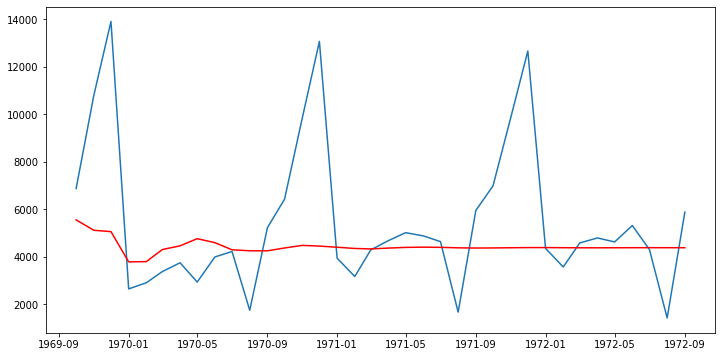

In [23]:
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

#Model 3: Autoregressive Integrated Moving Average (ARIMA)
##This model involves specifying the order for the AR(p), I(d), and MA(q) models

In [24]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0,8)
d = range(0,2)
q = range(0,1)

In [25]:
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# GRid Serach

In [27]:
best_aic = np.inf
best_pdq = None
temp_model = None
for param in pdq:   
    temp_model = ARIMA(train,order=param)
    results = temp_model.fit()
    if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param 
print("Best ARIMA {} model - AIC:{}".format(best_pdq,best_aic))  

Best ARIMA (4, 1, 0) model - AIC:1221.9586243360168


In [28]:
# using the best parameter in the model
model = ARIMA(train,order=(4,1,0))
model_fit = model.fit()

In [29]:

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

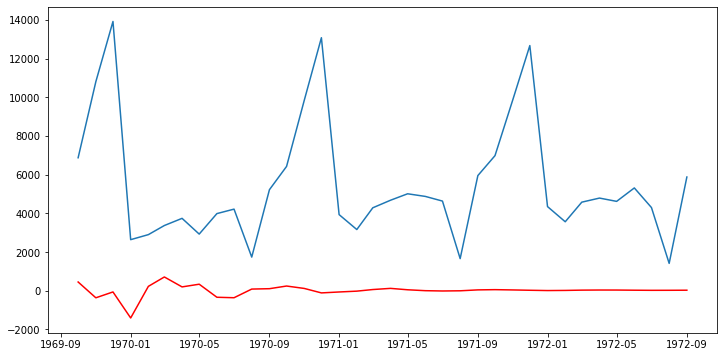

In [30]:
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [31]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test, predictions))
rmse = round(rmse, 3)

In [32]:
# Mean Absolute Percentage Error
abs_error = np.abs(test['Sales']-predictions)
actual = test['Sales']
mape = np.round(np.mean(np.abs(abs_error/actual)),3)

In [33]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Autoregressive Integrated Moving Average'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,1864.15,0.277
0,Autoregressive Integrated Moving Average,6327.05,1.000


#Seasonal Autoregressive Integrated Moving-Average (SARIMA)
##It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.

In [34]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [35]:
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [36]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [37]:
# using the best parameter in the model
model = SARIMAX(train,order=(0,1,1),seasonal_order=(1,1,1,12),enforce_invertibility=False,
                             enforce_stationarity=False)
model_fit = model.fit()

In [38]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

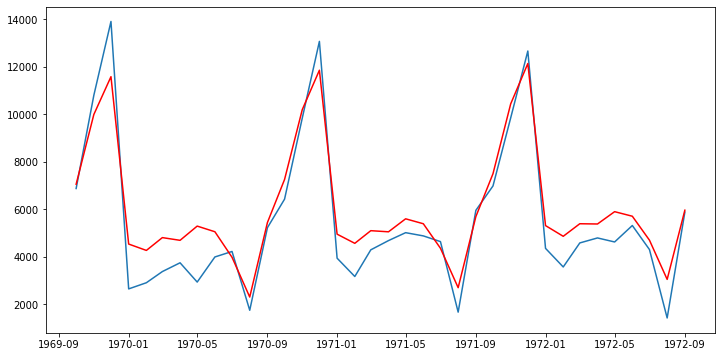

In [39]:
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [40]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], predictions))
rmse = round(rmse, 3)

In [41]:
# Mean Absolute Percentage Error
abs_error = np.abs(test['Sales']-predictions)
actual = test['Sales']
mape = np.round(np.mean(np.abs(abs_error/actual)),3)

In [42]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Seasonal Autoregressive Integrated Moving Average'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf.index = [i for i in range(len(resultsDf))]
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,1864.150,0.277
1,Autoregressive Integrated Moving Average,6327.050,1.000
2,Seasonal Autoregressive Integrated Moving Average,1035.182,0.235


#Plot of Champagne Sales with Test and Prediction along with Train

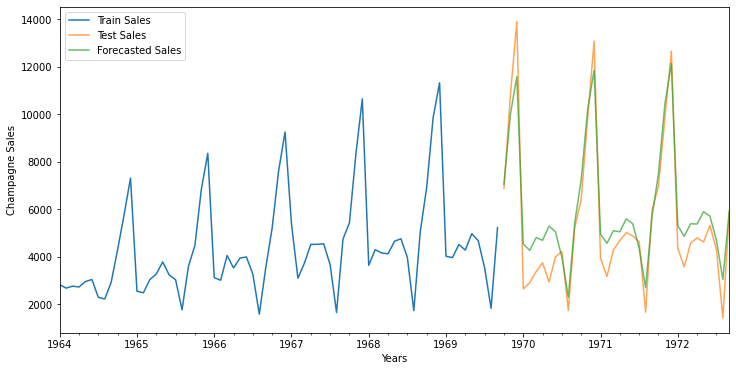

In [44]:
axis = train['Sales'].plot(label='Train Sales', figsize=(12, 6))
test['Sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
predictions.plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Champagne Sales')
plt.legend(loc='best')
plt.show()
plt.close()